# Introduction to Financial Engineering [IE471]
##  Hands-on Practice on Financial AI Session #2

### 1. Import Packages
#### Please import pandas_datareader package using 'pip install pandas_datareader'.

In [1]:
#data preprocessing
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler

#machine learning
import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### 2. Loading the Dataset

In [2]:
start = (2020, 1, 2)  # 2020-01-02 
start_time = datetime.datetime(*start)  
end = (2020, 12, 31) # 2020-12-31
end_time = datetime.datetime(*end) 

# Loading Samsung Electronic Co,. Ltd. (KS: 005930) Data from Yahoo Finance
df = pdr.DataReader('NVDA', 'yahoo', start_time, end_time)

In [3]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-02,239.910004,236.720001,238.750000,239.910004,5938400.0,239.514771
2020-01-03,237.830002,234.100006,235.100006,236.070007,5134600.0,235.681122
2020-01-06,237.270004,231.270004,232.320007,237.059998,6565900.0,236.669479
2020-01-07,241.770004,236.389999,238.199997,239.929993,7871400.0,239.534729
2020-01-08,242.039993,238.149994,239.759995,240.380005,6927700.0,239.984009


In [4]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-12-24,525.299988,517.549988,521.489990,519.750000,2447100.0,519.750000
2020-12-28,522.500000,510.529999,522.500000,516.000000,5314100.0,516.000000
2020-12-29,522.900024,513.690002,517.000000,517.729980,4259300.0,517.729980
2020-12-30,528.549988,515.869995,519.609985,525.830017,5634900.0,525.830017
2020-12-31,526.039978,516.599976,525.460022,522.200012,4810600.0,522.200012


In [5]:
X = df # Using high price, low price, Open price, Close price, Volume, and Adjusted Close Price to predict adjusted close price
y = df.iloc[:, 5:6] #Predicting adjusted close price

### 3. Scaling and Converting Data (Without Sentiment Analysis Results)

We can see that there is a big difference between volume and other values. In this case, LSTM models need to recognize the difference between these two scales: volume and the rest values, which can be a burden to train data. Therefore, we reduce by scaling all variables from 0 to 1 to reduce the burden on the model.

In [6]:
MMS = MinMaxScaler()

X_data = MMS.fit_transform(X)
y_data = MMS.fit_transform(y) 

# Input Variables (6 variables)
X_train = X_data[:188, :] #We trained January - September data including high price, low price, open price, close price, volume, and adj close data
X_test = X_data[188:252, :] #To verify trained model, we used October - December data as the test set

# Output Variables (adjusted close price)
y_train = y_data[1:189, :]
y_test = y_data[189:, :] 

print("Training Set Shape", X_train.shape, y_train.shape)
print("Testing Set Shape", X_test.shape, y_test.shape) 

Training Set Shape (188, 6) (188, 1)
Testing Set Shape (64, 6) (64, 1)


In [7]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([188, 1, 6]) torch.Size([188, 1])
Testing Shape torch.Size([64, 1, 6]) torch.Size([64, 1])


In [8]:
device = torch.device('cpu')

### 4. Building LSTM Model

In [9]:
class LSTM_model(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM_model, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length
 
    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True) #LSTM layer
    self.fc = nn.Linear(hidden_size, num_classes) #fully connected last layer

  def forward(self,x):
    h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
    # Propagate input through LSTM

    out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
    # Decode the hidden state of the last time step
    out = self.fc(out[:, -1, :])
    return out

### 5. Setting Hyperparameters and Training Data

In [10]:
num_epochs = 10000
learning_rate = 0.001

input_size = 6 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked LSTM layers

num_classes = 1 #number of output classes 
LSTM_1 = LSTM_model(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(LSTM_1.parameters(), lr=learning_rate)  # adam optimizer

In [11]:
for epoch in range(num_epochs+1):
    outputs = LSTM_1.forward(X_train_tensors_final.to(device)) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    # obtain the loss function
    loss = loss_function(outputs, y_train_tensors.to(device))

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop
    
    if epoch % 100 == 0:
        print("Epoch: %d, Loss: %1.4f" % (epoch, loss.item())) 

Epoch: 0, Loss: 0.6344
Epoch: 100, Loss: 0.2753
Epoch: 200, Loss: 0.0727
Epoch: 300, Loss: 0.0197
Epoch: 400, Loss: 0.0119
Epoch: 500, Loss: 0.0098
Epoch: 600, Loss: 0.0080
Epoch: 700, Loss: 0.0065
Epoch: 800, Loss: 0.0051
Epoch: 900, Loss: 0.0040
Epoch: 1000, Loss: 0.0031
Epoch: 1100, Loss: 0.0025
Epoch: 1200, Loss: 0.0020
Epoch: 1300, Loss: 0.0017
Epoch: 1400, Loss: 0.0015
Epoch: 1500, Loss: 0.0014
Epoch: 1600, Loss: 0.0013
Epoch: 1700, Loss: 0.0013
Epoch: 1800, Loss: 0.0013
Epoch: 1900, Loss: 0.0012
Epoch: 2000, Loss: 0.0012
Epoch: 2100, Loss: 0.0012
Epoch: 2200, Loss: 0.0012
Epoch: 2300, Loss: 0.0011
Epoch: 2400, Loss: 0.0011
Epoch: 2500, Loss: 0.0011
Epoch: 2600, Loss: 0.0011
Epoch: 2700, Loss: 0.0011
Epoch: 2800, Loss: 0.0011
Epoch: 2900, Loss: 0.0011
Epoch: 3000, Loss: 0.0010
Epoch: 3100, Loss: 0.0010
Epoch: 3200, Loss: 0.0010
Epoch: 3300, Loss: 0.0010
Epoch: 3400, Loss: 0.0010
Epoch: 3500, Loss: 0.0010
Epoch: 3600, Loss: 0.0010
Epoch: 3700, Loss: 0.0010
Epoch: 3800, Loss: 0.001

In [12]:
plt.rcParams["figure.figsize"] = (32,18)
plt.rcParams["figure.dpi"] = 300
plt.rcParams['axes.grid'] = True 
plt.rcParams.update({'font.size': 20})

### 6. Results

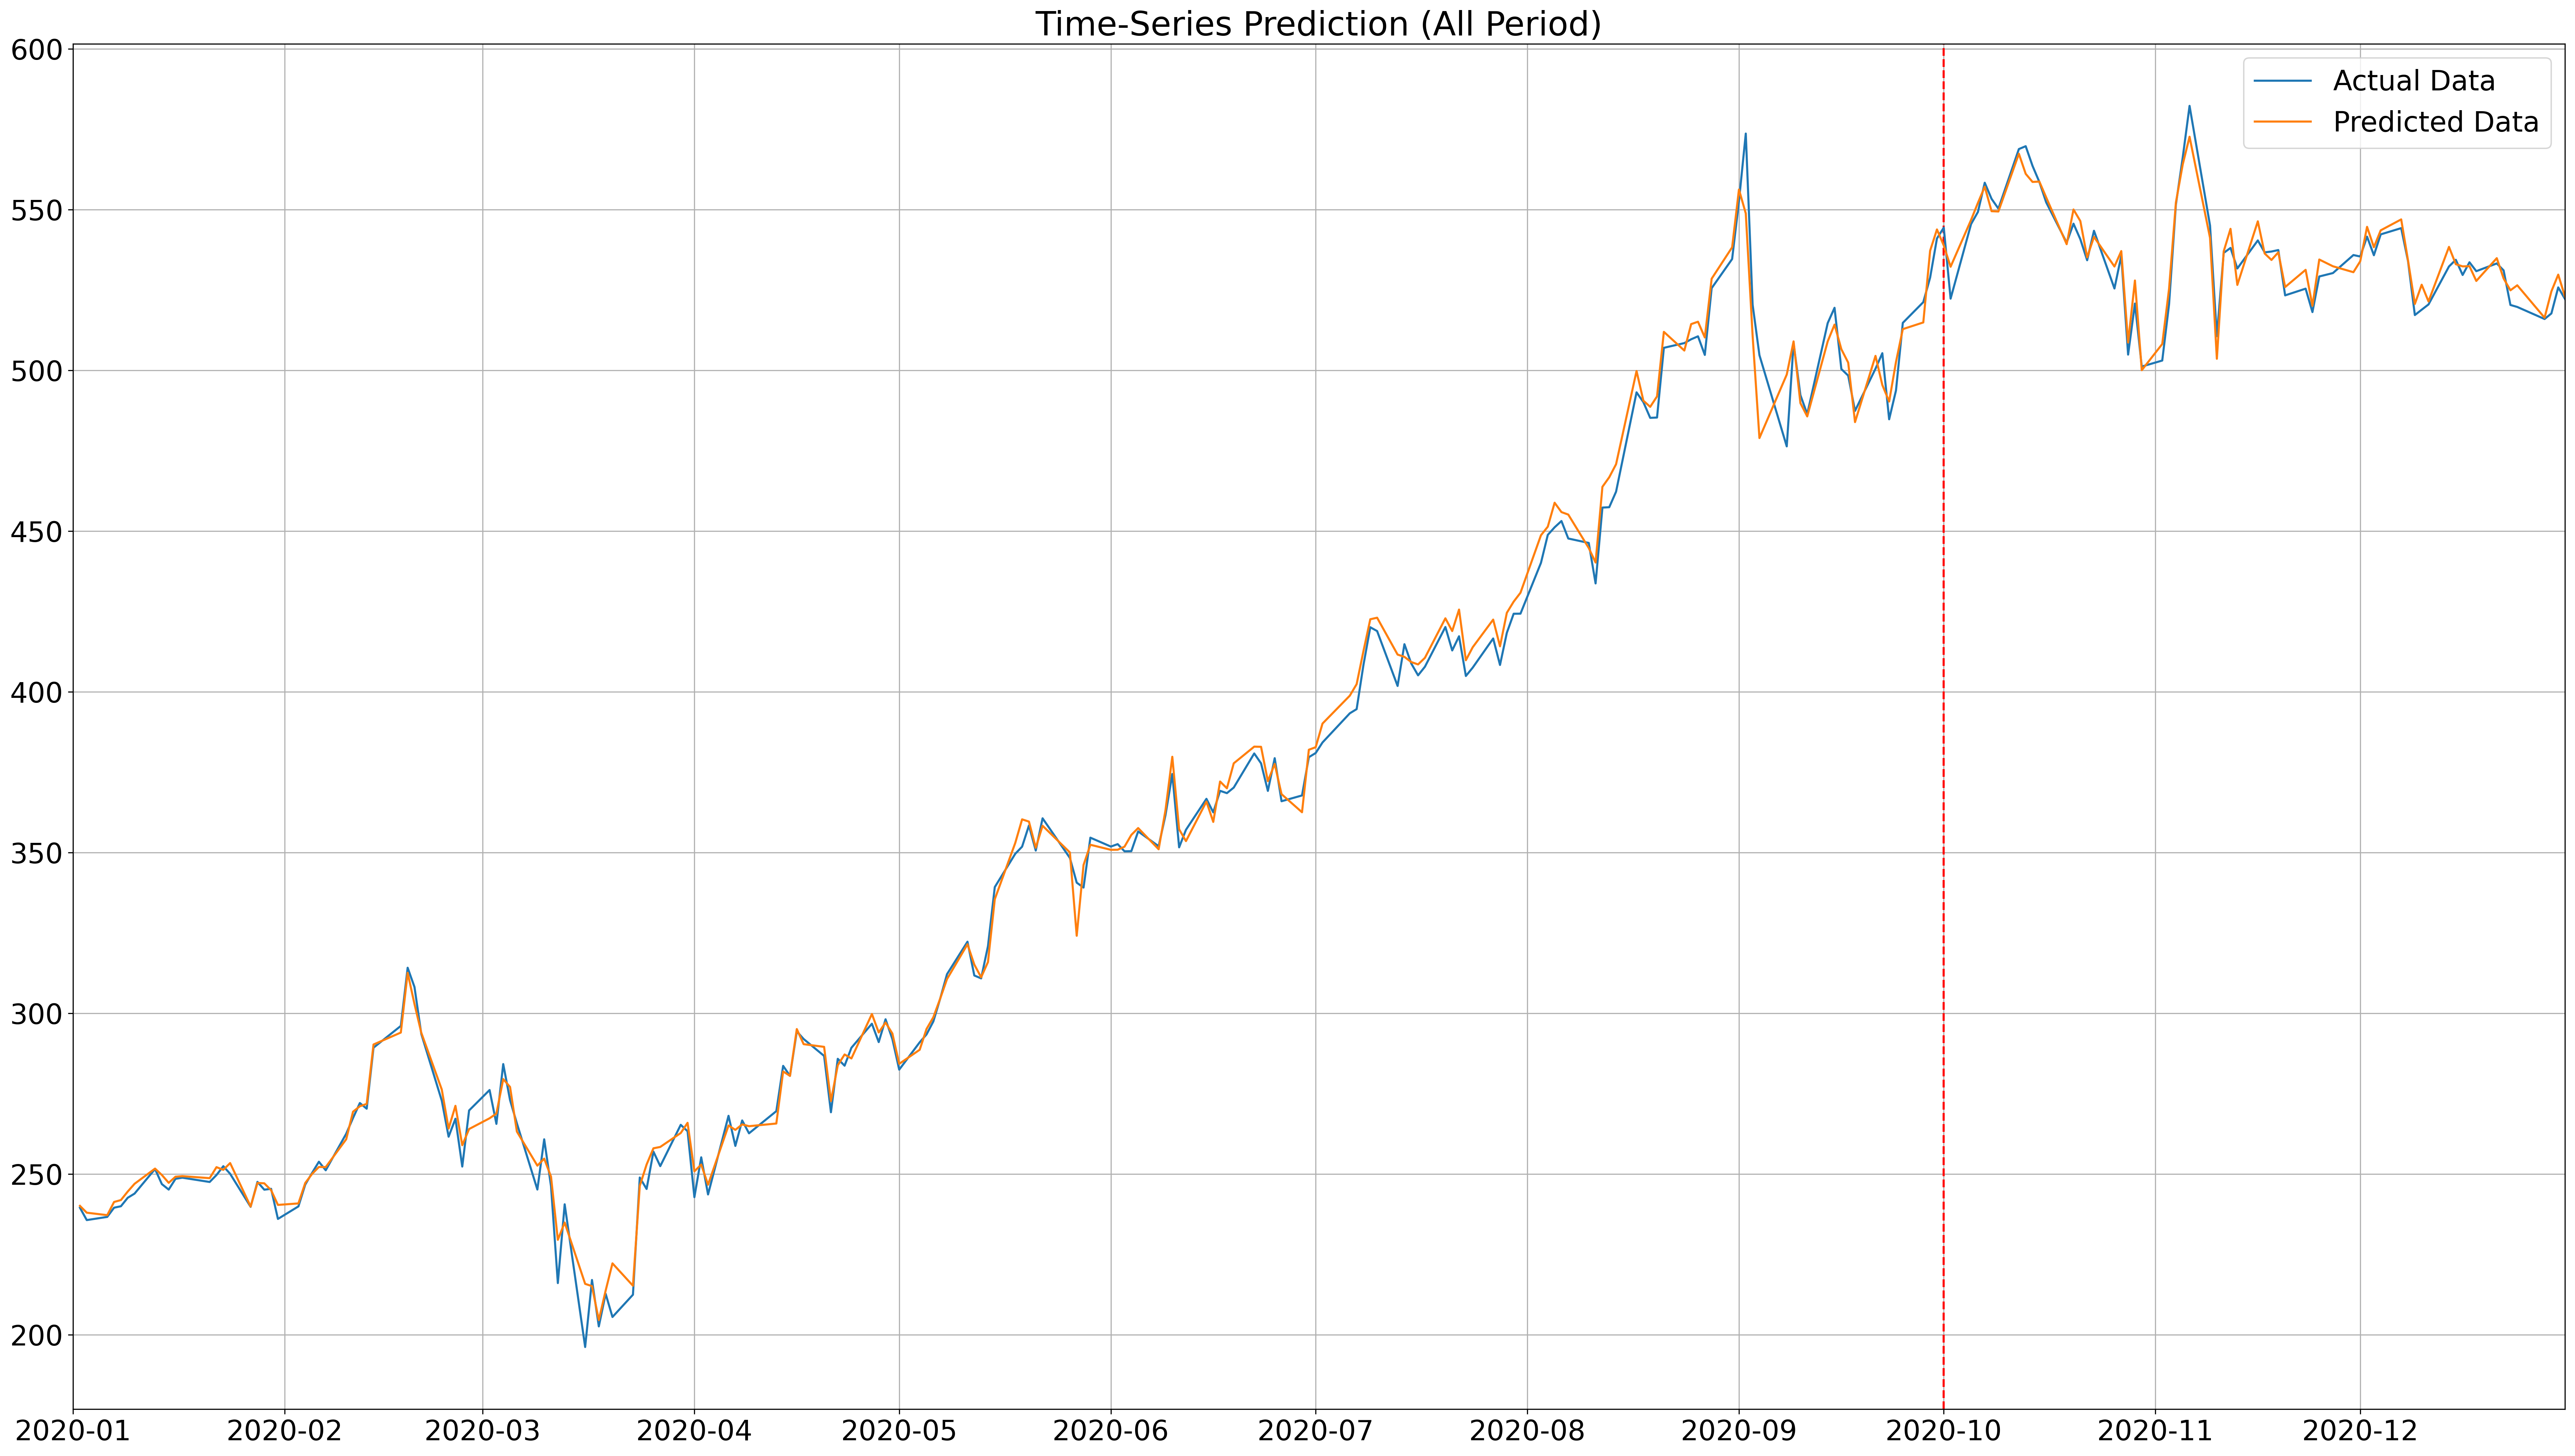

In [13]:
X_data = MMS.fit_transform(X)
y_data = MMS.fit_transform(y) 

df_X = Variable(torch.Tensor(X_data)) #converting to Tensors
df_y = Variable(torch.Tensor(y_data))
#reshaping the dataset
df_X = torch.reshape(df_X, (df_X.shape[0], 1, df_X.shape[1]))
train_predict = LSTM_1(df_X.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y.data.numpy()

data_predict = MMS.inverse_transform(data_predict) #reverse transformation
dataY_plot = MMS.inverse_transform(dataY_plot)

plt.xlim(datetime.datetime(2020, 1, 1), datetime.datetime(2020, 12, 31))
test_line = datetime.datetime(2020, 10, 1)
plt.axvline(x=test_line, c='r', linestyle='--') #size of the training set

plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime(), data_predict, label='Predicted Data') # plot for predicted data
plt.title('Time-Series Prediction (All Period)')
plt.legend()
plt.show() 

In [14]:
MSE = float(sum((dataY_plot - data_predict)*(dataY_plot - data_predict))/len(data_predict))
print('Mean Squared Error:', MSE)

Mean Squared Error: 28.747270584106445


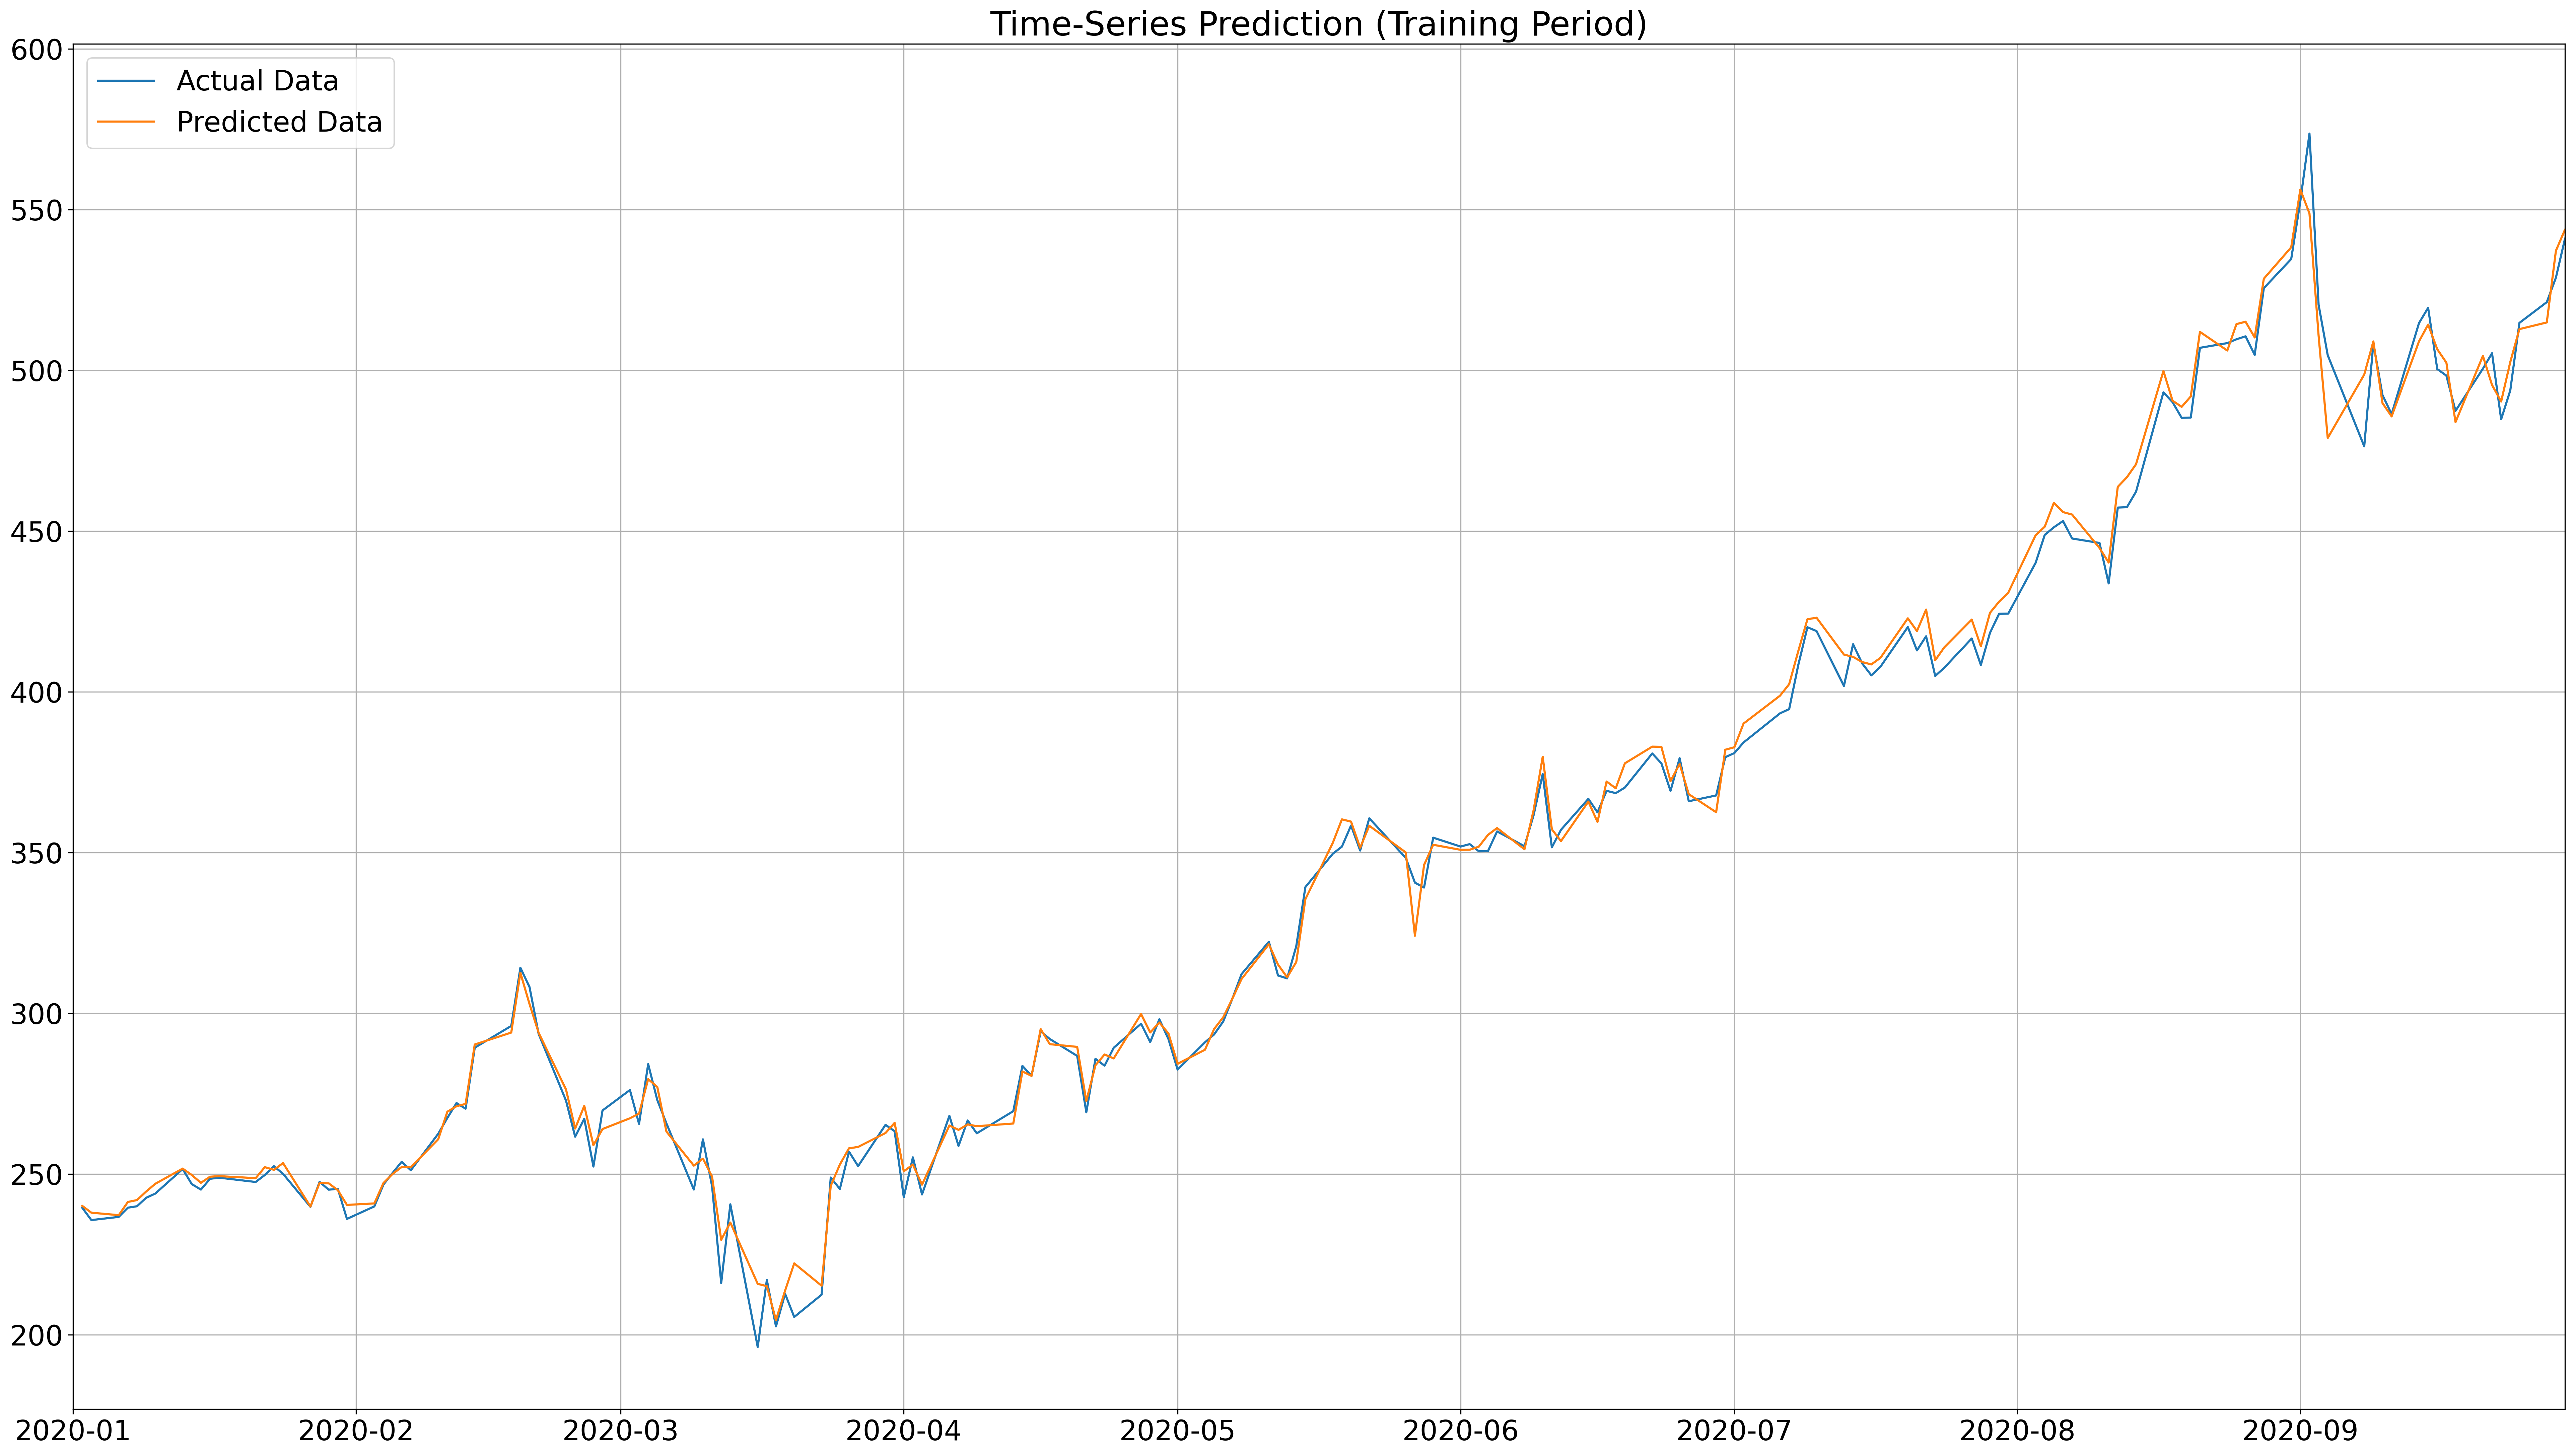

In [15]:
plt.xlim(datetime.datetime(2020, 1, 1), datetime.datetime(2020, 9, 30))
plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime(), data_predict, label='Predicted Data') # plot for predicted data
plt.title('Time-Series Prediction (Training Period)')
plt.legend()
plt.show() 

In [16]:
MSE_train = float(sum((dataY_plot[0:188] - data_predict[0:188])*(dataY_plot[0:188] - data_predict[0:188]))/len(data_predict[0:189]))
print('Mean Squared Error (Training Data):', MSE_train)

Mean Squared Error (Training Data): 32.369991302490234


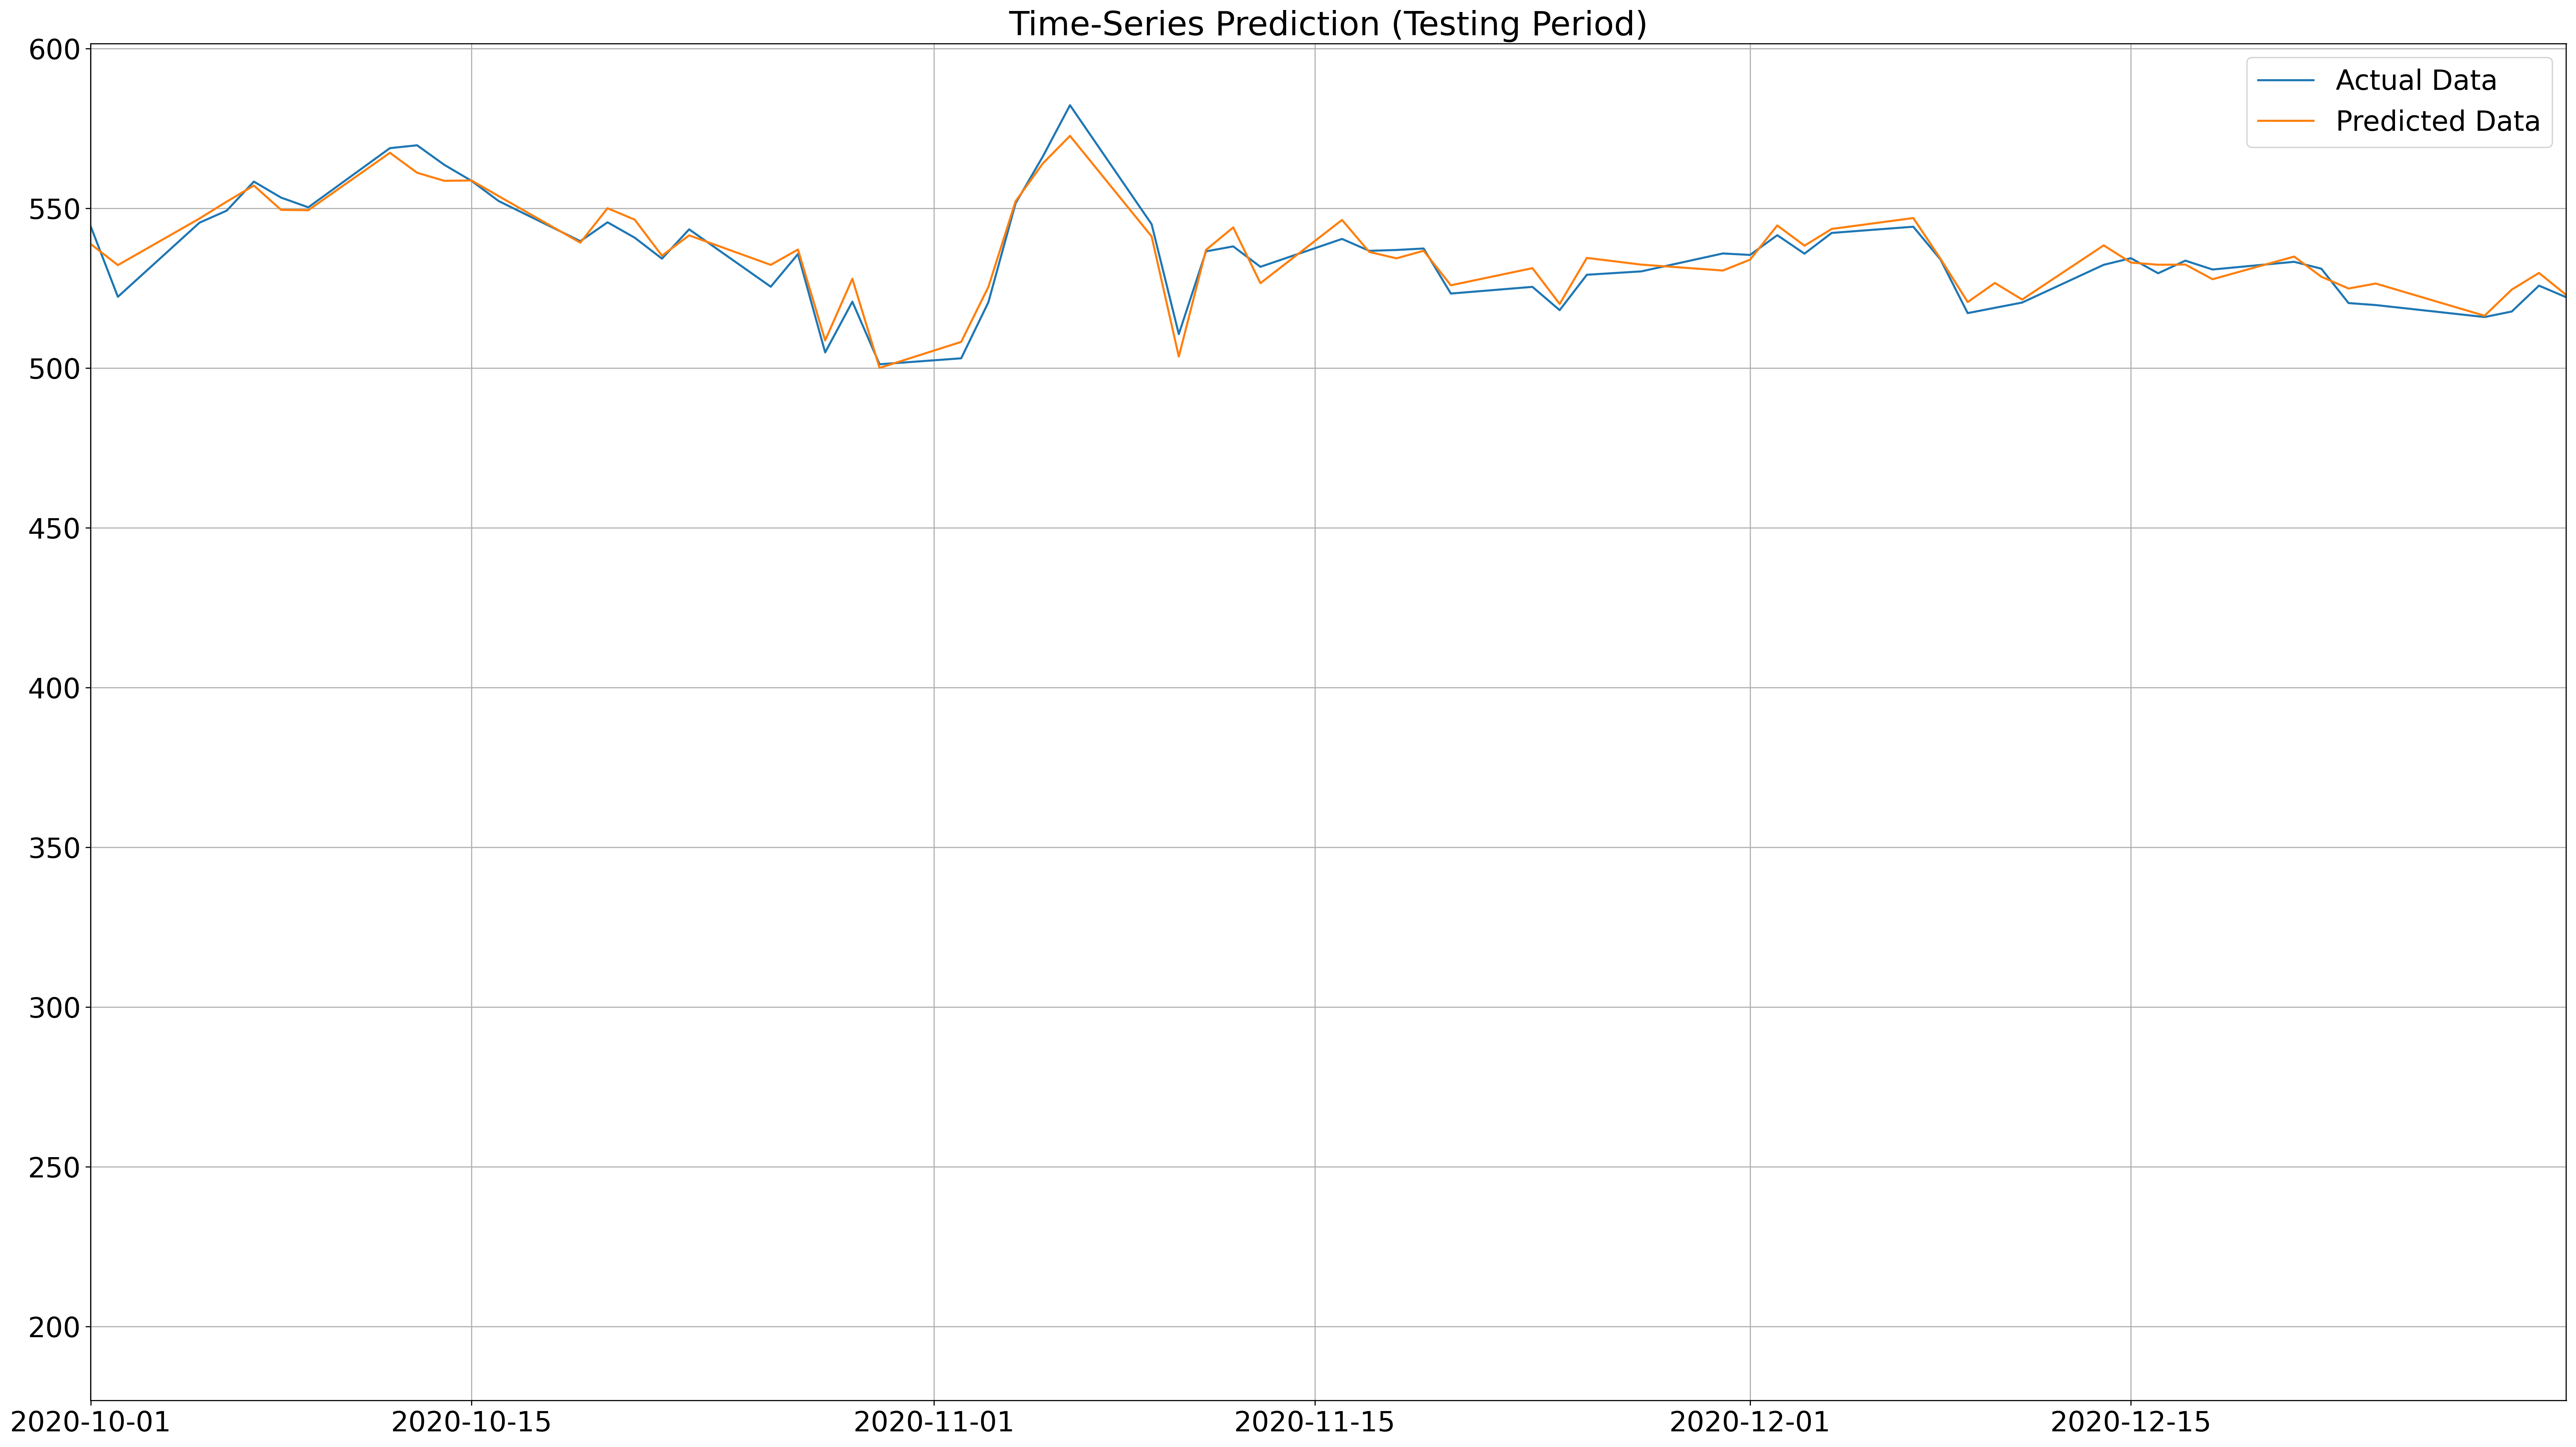

In [17]:
plt.xlim(datetime.datetime(2020, 10, 1), datetime.datetime(2020, 12, 31))
plt.plot(df.index.to_pydatetime(), dataY_plot, label='Actual Data') # plot for actual data
plt.plot(df.index.to_pydatetime(), data_predict, label='Predicted Data') # plot for predicted data
plt.title('Time-Series Prediction (Testing Period)')
plt.legend()
plt.show() 

In [18]:
MSE_test = float(sum((dataY_plot[188:] - data_predict[188:])*(dataY_plot[188:] - data_predict[188:]))/len(data_predict[188:]))
print('Mean Squared Error (Test Data):', MSE_test)

Mean Squared Error (Test Data): 17.77124786376953


In [19]:
with torch.no_grad():
    torch.save(LSTM_1, 'saved_models/nvidia_lstm.pt')